In [1]:
# regular imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import math

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

import warnings
warnings.filterwarnings("ignore")

# Wrangling
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.cluster import KMeans
from scipy import stats
import sklearn.preprocessing
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr, kruskal

import csv
import acquire
import prepare
import ds_acquire
import ds_prepare


In [2]:
df = acquire.get_bach_df()
df = prepare.clean_college_df(df)

dataframe shape: (71901, 119)


In [3]:
df['major_category'] = df.major_name.apply(prepare.categorize_major)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71901 entries, 0 to 224838
Columns: 120 entries, unit_id_institution to major_category
dtypes: float64(85), int64(2), object(33)
memory usage: 66.4+ MB


In [5]:
df.head()

,unit_id_institution,college_name,institution_control,state_post_code,zip_code,city,region_ipeds,title_IV_eligibility,pred_degree,pred_degree_0and4,...,deg_percent_awarded_construction_trades,deg_percent_awarded_mechanic_repair,deg_percent_awarded_precision_production,deg_percent_awarded_transportation_materials,deg_percent_awarded_visual_and_performing_arts,deg_percent_awarded_health,deg_percent_awarded_business_management,deg_percent_awarded_history,non_deg_seeking,major_category
0,"100,654.00",Alabama A & M University,Public,AL,35762,Normal,5.00,1.00,3.00,3.00,...,0.00,0.00,0.00,0.00,0.02,0.00,0.16,0.00,153.00,Agriculture
1,"100,654.00",Alabama A & M University,Public,AL,35762,Normal,5.00,1.00,3.00,3.00,...,0.00,0.00,0.00,0.00,0.02,0.00,0.16,0.00,153.00,Biology and Life Sciences
2,"100,654.00",Alabama A & M University,Public,AL,35762,Normal,5.00,1.00,3.00,3.00,...,0.00,0.00,0.00,0.00,0.02,0.00,0.16,0.00,153.00,Biology and Life Sciences
5,"100,654.00",Alabama A & M University,Public,AL,35762,Normal,5.00,1.00,3.00,3.00,...,0.00,0.00,0.00,0.00,0.02,0.00,0.16,0.00,153.00,Biology and Life Sciences
6,"100,654.00",Alabama A & M University,Public,AL,35762,Normal,5.00,1.00,3.00,3.00,...,0.00,0.00,0.00,0.00,0.02,0.00,0.16,0.00,153.00,Agriculture


# _______________________________________________________________________________________________ #
### Initial `earnings_df`

In [6]:
earnings_df = pd.read_csv('earnings_df.csv')

In [7]:
earnings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707462 entries, 0 to 707461
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   Unnamed: 0                707462 non-null  int64 
 1   earning_year              707462 non-null  int64 
 2   earnings_degree           707462 non-null  int64 
 3   earnings_school_type      707462 non-null  int64 
 4   earnings_major            707462 non-null  int64 
 5   earnings_wage/salary      707462 non-null  int64 
 6   EMPSTAT                   707462 non-null  int64 
 7   METRO                     707462 non-null  int64 
 8   SEX                       707462 non-null  int64 
 9   AGE                       707462 non-null  int64 
 10  earnings_race             707462 non-null  int64 
 11  earnings_speaks_english   707462 non-null  int64 
 12  LANGUAGE                  707462 non-null  int64 
 13  earnings_specific_degree  707462 non-null  int64 
 14  stat

In [8]:
earnings_df.head()

,Unnamed: 0,earning_year,earnings_degree,earnings_school_type,earnings_major,earnings_wage/salary,EMPSTAT,METRO,SEX,AGE,earnings_race,earnings_speaks_english,LANGUAGE,earnings_specific_degree,state_post_code,major_category
0,2762990,2017,101,1,61,38500,1,0,2,31,1,3,1,6100,AL,Medical and Health Sciences and Services
1,2763006,2017,101,1,62,120000,1,4,1,30,2,3,1,6203,AL,Business
2,2763007,2017,101,1,40,50000,1,4,1,26,2,3,1,4002,AL,Interdisciplinary and Multi-Disciplinary Studi...
3,2763029,2017,101,1,61,65000,1,4,2,49,1,3,1,6107,AL,Medical and Health Sciences and Services
4,2763031,2017,101,1,33,42000,1,4,2,34,1,3,1,3301,AL,"English Language, Literature, and Composition"


# _______________________________________________________________________________________________ #
### `earnings_df` pivot table to merge with main df
Newly created pivot table with median earnings by major_category, split by year

In [9]:
earnings_pivot_merge = pd.read_csv('2017_2018_2019_earning_by_major.csv')

In [10]:
earnings_pivot_merge

,major_category,2017,2018,2019,Grand Total
0,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49"
1,Architecture,"68,643.59","71,344.26","75,609.81","215,597.67"
2,"Area, Ethnic, and Civilization Studies","53,999.93","56,155.89","60,997.54","171,153.36"
3,Biology and Life Sciences,"48,851.91","50,004.54","53,463.29","152,319.74"
4,Business,"74,813.94","76,724.07","79,608.39","231,146.40"
5,Communication Technologies,"50,630.58","53,303.00","56,882.68","160,816.25"
6,Communications,"61,311.56","63,458.16","66,997.75","191,767.47"
7,Computer and Information Sciences,"83,482.41","87,552.61","91,321.98","262,357.00"
8,Construction Services,"85,101.29","85,776.30","91,583.25","262,460.84"
9,Cosmetology Services and Culinary Arts,"42,217.78","45,696.22","48,408.92","136,322.92"


In [11]:
new_df = df.merge(earnings_pivot_merge, how='inner', on='major_category')

In [59]:
new_df.shape

(71422, 125)

In [12]:
new_df.head()

,unit_id_institution,college_name,institution_control,state_post_code,zip_code,city,region_ipeds,title_IV_eligibility,pred_degree,pred_degree_0and4,...,deg_percent_awarded_visual_and_performing_arts,deg_percent_awarded_health,deg_percent_awarded_business_management,deg_percent_awarded_history,non_deg_seeking,major_category,2017,2018,2019,Grand Total
0,"100,654.00",Alabama A & M University,Public,AL,35762,Normal,5.00,1.00,3.00,3.00,...,0.02,0.00,0.16,0.00,153.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49"
1,"100,654.00",Alabama A & M University,Public,AL,35762,Normal,5.00,1.00,3.00,3.00,...,0.02,0.00,0.16,0.00,153.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49"
2,"100,858.00",Auburn University,Public,AL,36849,Auburn,5.00,1.00,3.00,3.00,...,0.03,0.06,0.23,0.01,481.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49"
3,"100,858.00",Auburn University,Public,AL,36849,Auburn,5.00,1.00,3.00,3.00,...,0.03,0.06,0.23,0.01,481.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49"
4,"101,541.00",Judson College,"Private, nonprofit",AL,36756,Marion,5.00,1.00,3.00,3.00,...,0.07,0.24,0.10,0.04,9.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49"


In [13]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71422 entries, 0 to 71421
Columns: 124 entries, unit_id_institution to Grand Total
dtypes: float64(89), int64(2), object(33)
memory usage: 68.1+ MB


In [14]:
# new_df.to_csv('merged_df.csv')

In [15]:
new_df.avg_net_price_public.isnull().sum()

42789

In [16]:
71422 - 42789

28633

In [17]:
new_df.avg_net_price_private.isnull().sum()

33337

In [18]:
new_df.avg_net_price_public.value_counts()

15,020.00    153
15,970.00    140
30,996.00    138
12,566.00    136
17,704.00    125
            ... 
 6,526.00      1
 4,646.00      1
 8,324.00      1
 3,411.00      1
 4,433.00      1
Name: avg_net_price_public, Length: 759, dtype: int64

In [19]:
price_investigation = new_df.groupby(new_df['institution_control'])['avg_net_price_public'].value_counts()

In [20]:
priv_price_investigation = new_df.groupby(new_df['institution_control'])['avg_net_price_private'].value_counts()

In [21]:
price_investigation.info()

<class 'pandas.core.series.Series'>
MultiIndex: 759 entries, ('Public', 15020.0) to ('Public', 44661.0)
Series name: avg_net_price_public
Non-Null Count  Dtype
--------------  -----
759 non-null    int64
dtypes: int64(1)
memory usage: 14.2+ KB


In [22]:
priv_price_investigation.info()

<class 'pandas.core.series.Series'>
MultiIndex: 1547 entries, ('Private, for-profit', 21197.0) to ('Public', 27000.0)
Series name: avg_net_price_private
Non-Null Count  Dtype
--------------  -----
1547 non-null   int64
dtypes: int64(1)
memory usage: 28.8+ KB


In [23]:
price_investigation.to_csv('price_investigation.csv')

In [24]:
priv_price_investigation.to_csv('priv_price_investigation.csv')

In [25]:
# new_df.groupby(new_df['institution_control']=='Public')['avg_net_price_private'].value_counts()

In [26]:
new_df.avg_net_price_private

0                        NaN
1                        NaN
2                        NaN
3                        NaN
4                  16,619.00
                ...         
71417                    NaN
71418                    NaN
71419              29,386.00
71420              18,182.00
71421                    NaN
Name: avg_net_price_private, Length: 71422, dtype: float64

In [27]:
new_df.avg_net_price_program.isnull().sum()

71422

In [28]:
new_df.avg_net_price_other.isnull().sum()

71422

In [29]:
new_df.avg_net_price_public

0                  14,444.00
1                  14,444.00
2                  23,696.00
3                  23,696.00
4                        NaN
                ...         
71417              19,836.00
71418              22,282.00
71419                    NaN
71420                    NaN
71421              12,566.00
Name: avg_net_price_public, Length: 71422, dtype: float64

In [30]:
# new_df.replace(to_replace=new_df['avg_net_price_public'] == 'NaN', value=None)

In [31]:
new_df.avg_net_price_public

0                  14,444.00
1                  14,444.00
2                  23,696.00
3                  23,696.00
4                        NaN
                ...         
71417              19,836.00
71418              22,282.00
71419                    NaN
71420                    NaN
71421              12,566.00
Name: avg_net_price_public, Length: 71422, dtype: float64

For sake of expedition, we are not completing individual application of joining avg_net_price columns.
Instead, Chenchen is uploading her new csv file with appropriate changes to the Google Drive so we can press forward with exploration.

In [2]:
explore_df = pd.read_csv('merged_df_with_avg_price.csv')

In [40]:
explore_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71422 entries, 0 to 71421
Columns: 126 entries, Unnamed: 0 to avg_net_price
dtypes: float64(115), int64(3), object(8)
memory usage: 68.7+ MB


In [41]:
explore_df.head()

,Unnamed: 0,unit_id_institution,college_name,institution_control,state_post_code,zip_code,city,region_ipeds,title_IV_eligibility,pred_degree,...,deg_percent_awarded_health,deg_percent_awarded_business_management,deg_percent_awarded_history.1,non_deg_seeking,major_category,2017,2018,2019,Grand Total,avg_net_price
0,0,"100,654.00",Alabama A & M University,Public,AL,35762,Normal,5.00,1.00,3.00,...,0.00,0.16,0.00,153.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","14,444.00"
1,1,"100,654.00",Alabama A & M University,Public,AL,35762,Normal,5.00,1.00,3.00,...,0.00,0.16,0.00,153.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","14,444.00"
2,2,"100,858.00",Auburn University,Public,AL,36849,Auburn,5.00,1.00,3.00,...,0.06,0.23,0.01,481.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","23,696.00"
3,3,"100,858.00",Auburn University,Public,AL,36849,Auburn,5.00,1.00,3.00,...,0.06,0.23,0.01,481.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","23,696.00"
4,4,"101,541.00",Judson College,"Private, nonprofit",AL,36756,Marion,5.00,1.00,3.00,...,0.24,0.10,0.04,9.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","16,619.00"


# _______________________________________________________________________________________________ #
## ROI Target Variable Feature Engineering
Creating the ROI formula to create new column with ROI value for each college/major

**Formula:**
ROI =[ 10-yr earnings by degree ] - [College Cost (tuition,fees,books) + Counter Earnings(14-yr earnings of HS diploma ]

# _________________________________ #
##### 5-yr ROI

In [3]:
median_earnings_by_degree_5yr = (explore_df['2017'] + explore_df['2018'] + explore_df['2019'] + explore_df['2019']*1.02 + (explore_df['2019']*1.02)*1.02)

In [4]:
net_college_cost = explore_df['avg_net_price']

In [5]:

counter_earnings_5yr = (39070*9)

In [6]:
explore_df['roi_5yr'] = median_earnings_by_degree_5yr - (net_college_cost+counter_earnings_5yr)

In [7]:
explore_df['roi_5yr']

0                 -65,075.75
1                 -65,075.75
2                 -74,327.75
3                 -74,327.75
4                 -67,250.75
                ...         
71417            -197,026.85
71418            -199,472.85
71419            -206,576.85
71420            -195,372.85
71421            -189,756.85
Name: roi_5yr, Length: 71422, dtype: float64

# _________________________________ #
##### 10-yr ROI

In [8]:
median_earnings_by_degree_10yr = (explore_df['2017'] + explore_df['2018'] + explore_df['2019'] + explore_df['2019']*1.02 + (explore_df['2019']*1.02)*1.02) + ((explore_df['2019']*1.02)*1.02)*1.02 + (((explore_df['2019']*1.02)*1.02)*1.02)*1.02 + ((((explore_df['2019']*1.02)*1.02)*1.02)*1.02)*1.02 + (((((explore_df['2019']*1.02)*1.02)*1.02)*1.02)*1.02)*1.02 + ((((((explore_df['2019']*1.02)*1.02)*1.02)*1.02)*1.02)*1.02)*1.02

In [9]:
# net_college_cost = explore_df['avg_net_price']

In [10]:

counter_earnings_10yr = (39070*14)

In [11]:
explore_df['roi_10yr'] = median_earnings_by_degree_10yr - (net_college_cost+counter_earnings_10yr)

In [12]:
explore_df['roi_10yr']

0                  78,598.88
1                  78,598.88
2                  69,346.88
3                  69,346.88
4                  76,423.88
                ...         
71417            -217,577.31
71418            -220,023.31
71419            -227,127.31
71420            -215,923.31
71421            -210,307.31
Name: roi_10yr, Length: 71422, dtype: float64

In [13]:
explore_df['roi_10yr'].value_counts()

 287,834.37    828
  67,253.91    469
 407,868.78    426
   8,110.75    385
 232,829.01    260
              ... 
 -38,878.57      1
 -30,333.57      1
 -48,016.57      1
 -50,257.57      1
-210,307.31      1
Name: roi_10yr, Length: 30287, dtype: int64

In [14]:
explore_df.shape

(71422, 128)

In [15]:
explore_df.head()

,Unnamed: 0,unit_id_institution,college_name,institution_control,state_post_code,zip_code,city,region_ipeds,title_IV_eligibility,pred_degree,...,deg_percent_awarded_history.1,non_deg_seeking,major_category,2017,2018,2019,Grand Total,avg_net_price,roi_5yr,roi_10yr
0,0,"100,654.00",Alabama A & M University,Public,AL,35762,Normal,5.00,1.00,3.00,...,0.00,153.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","14,444.00","-65,075.75","78,598.88"
1,1,"100,654.00",Alabama A & M University,Public,AL,35762,Normal,5.00,1.00,3.00,...,0.00,153.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","14,444.00","-65,075.75","78,598.88"
2,2,"100,858.00",Auburn University,Public,AL,36849,Auburn,5.00,1.00,3.00,...,0.01,481.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","23,696.00","-74,327.75","69,346.88"
3,3,"100,858.00",Auburn University,Public,AL,36849,Auburn,5.00,1.00,3.00,...,0.01,481.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","23,696.00","-74,327.75","69,346.88"
4,4,"101,541.00",Judson College,"Private, nonprofit",AL,36756,Marion,5.00,1.00,3.00,...,0.04,9.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","16,619.00","-67,250.75","76,423.88"


In [16]:
explore_df['deg_percent_awarded_history.1'].sum()

866.0209999999998

In [17]:
explore_df.groupby(explore_df['unit_id_institution'])['deg_percent_awarded_history.1'].sum()

unit_id_institution
100,654.00                   0.00
100,663.00                   0.46
100,690.00                   0.00
100,706.00                   0.41
100,724.00                   0.14
                     ...         
494,287.00                   0.00
494,630.00                   0.00
494,685.00                   0.00
494,737.00                   0.00
494,807.00                   0.00
Name: deg_percent_awarded_history.1, Length: 2706, dtype: float64

In [18]:
explore_df.deg_percent_awarded_engineering

0                       0.12
1                       0.12
2                       0.19
3                       0.19
4                       0.00
                ...         
71417                   0.00
71418                   0.00
71419                   0.00
71420                   0.00
71421                   0.10
Name: deg_percent_awarded_engineering, Length: 71422, dtype: float64

In [19]:
explore_df.groupby(explore_df['college_name'])['deg_percent_awarded_engineering'].agg([sum, 'mean', 'median'], axis=1)

,sum,mean,median
college_name,,,
AI Miami International University of Art and Design,0.00,0.00,0.00
ASA College,0.00,0.00,0.00
ATA College,0.00,0.00,0.00
ATI College-Norwalk,0.00,0.00,0.00
Aarhus University,0.00,NaN,NaN
...,...,...,...
York College of Pennsylvania,3.02,0.06,0.06
York St John University,0.00,NaN,NaN
York University,0.00,NaN,NaN


In [20]:
explore_df.college_name.nunique()

3002

In [21]:
# explore_df.to_csv('df_exploration_ready_with_ROI.csv')

# __________________________________________________________________________________ #
# Exploration

### Variables to explore:

- `avg_net_price`
- `full_time_net_tuition_revenue`
- `avg_faculty_salary`

- `admission_rate`
- `ACT_score_mid`
- `avg_sat_admitted`
- `required_score`
- `share_of_part_time`


In [1]:
# regular imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import math

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

import warnings
warnings.filterwarnings("ignore")

# Wrangling
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.cluster import KMeans
from scipy import stats
import sklearn.preprocessing
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr, kruskal

import csv
import acquire
import prepare
import ds_acquire
import ds_prepare


In [2]:
explore_df = pd.read_csv('df_exploration_ready_with_ROI.csv')

In [3]:
explore_df.head()

,Unnamed: 0,unit_id_institution,college_name,institution_control,state_post_code,zip_code,city,region_ipeds,title_IV_eligibility,pred_degree,...,deg_percent_awarded_history.1,non_deg_seeking,avg_net_price,major_category,2017,2018,2019,Grand Total,roi_5yr,roi_10yr
0,0,"100,654.00",Alabama A & M University,Public,AL,35762,Normal,5.00,1.00,3.00,...,0.00,153.00,"14,444.00",Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","-65,075.75","78,598.88"
1,1,"100,654.00",Alabama A & M University,Public,AL,35762,Normal,5.00,1.00,3.00,...,0.00,153.00,"14,444.00",Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","-65,075.75","78,598.88"
2,2,"100,858.00",Auburn University,Public,AL,36849,Auburn,5.00,1.00,3.00,...,0.01,481.00,"23,696.00",Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","-74,327.75","69,346.88"
3,3,"100,858.00",Auburn University,Public,AL,36849,Auburn,5.00,1.00,3.00,...,0.01,481.00,"23,696.00",Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","-74,327.75","69,346.88"
4,4,"101,541.00",Judson College,"Private, nonprofit",AL,36756,Marion,5.00,1.00,3.00,...,0.04,9.00,"16,619.00",Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","-67,250.75","76,423.88"


In [ ]:
explore_df.describe()

In [ ]:
explore_df.avg_net_price.

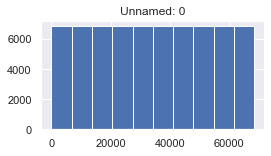

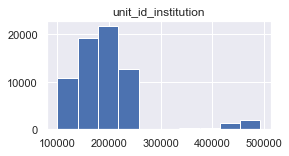

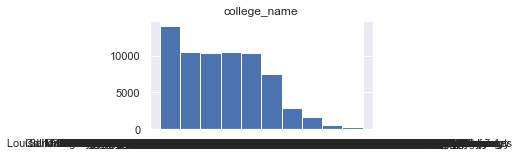

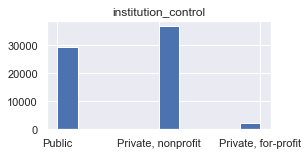

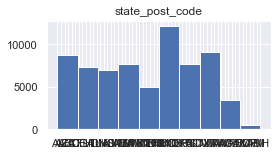

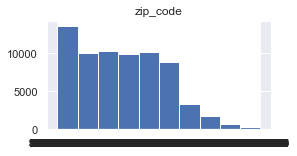

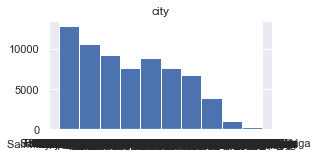

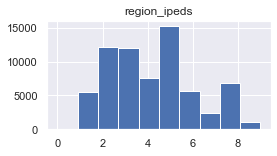

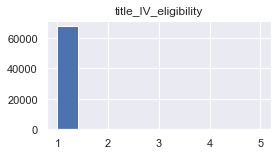

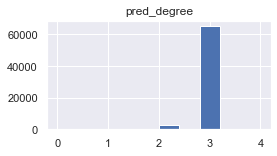

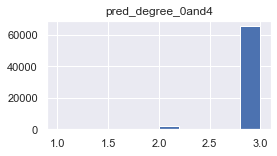

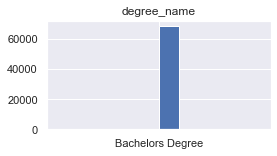

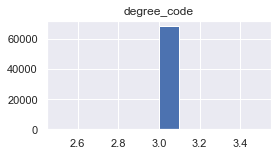

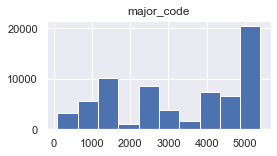

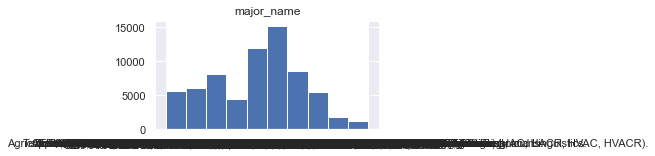

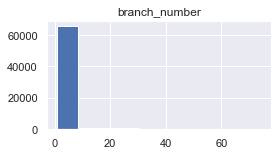

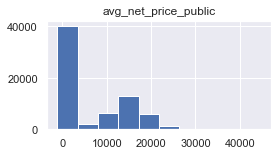

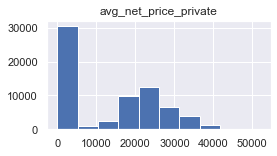

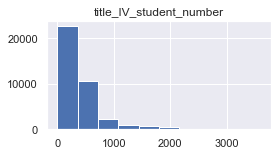

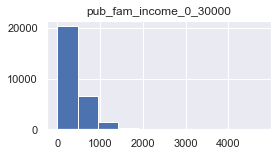

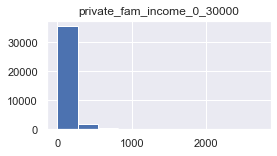

ValueError: autodetected range of [nan, nan] is not finite

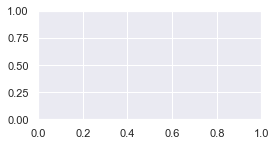

In [4]:
# Histogram showing distribution of all cols
for col in explore_df.columns:
    plt.figure(figsize=(4,2))
    plt.hist(explore_df[col])
    plt.title(col)
    plt.show()

In [6]:
# Creating a snapshot of our data, variables, and their relationships
sns.pairplot(explore_df.sample(2000), kind='reg', corner=True, plot_kws={'line_kws':{'color':'red'}})

In [ ]:
print("Is there a relationship between avg_net_price and ROI_10yr?")
sns.jointplot(x="avg_net_price", y="roi_10yr", data=explore_df)
plt.xlabel("Avg_net_price_per_institution")
plt.ylabel("ROI 10yr")
plt.show()

In [ ]:
print("Is there a relationship between full_time_net_tuition_revenue and ROI_10yr?")
sns.jointplot(x="full_time_net_tuition_revenue", y="roi_10yr", data=explore_df)
plt.xlabel("Fill Time Net Tuition Revenue")
plt.ylabel("ROI 10yr")
plt.show()

In [ ]:
print("Is there a relationship between avg_faculty_salary and ROI_10yr?")
sns.jointplot(x="avg_faculty_salary", y="roi_10yr", data=explore_df)
plt.xlabel("Avg Faculty Salary")
plt.ylabel("ROI 10yr")
plt.show()

In [ ]:
print("Is there a relationship between admission_rate and ROI_10yr?")
sns.jointplot(x="admission_rate", y="roi_10yr", data=explore_df)
plt.xlabel("Admission Rate")
plt.ylabel("ROI 10yr")
plt.show()

In [ ]:
print("Is there a relationship between ACT_score_mid and ROI_10yr?")
sns.jointplot(x="ACT_score_mid", y="roi_10yr", data=explore_df)
plt.xlabel("Mid ACT score admitted")
plt.ylabel("ROI 10yr")
plt.show()

In [ ]:
print("Is there a relationship between avg_sat_admitted and ROI_10yr?")
sns.jointplot(x="avg_sat_admitted", y="roi_10yr", data=explore_df)
plt.xlabel("Avg SAT score admitted")
plt.ylabel("ROI 10yr")
plt.show()

In [ ]:
print("Is there a relationship between required_score and ROI_10yr?")
sns.jointplot(x="required_score", y="roi_10yr", data=explore_df)
plt.xlabel("Required Score (unsure which score)")
plt.ylabel("ROI 10yr")
plt.show()

In [ ]:
print("Is there a relationship between share_of_part_time and ROI_10yr?")
sns.jointplot(x="share_of_part_time", y="roi_10yr", data=explore_df)
plt.xlabel("Portion of part time students")
plt.ylabel("ROI 10yr")
plt.show()

# ___________________________________________ #
### Train_Test_Split for further exploration

In [ ]:
train, validate, test = prepare.split_data(explore_df)


In [ ]:
# Define function which plots a categorical and continuous var
def plot_categorical_and_continuous_vars(df, categorical, continuous):
    df_sample = df.sample(2000)
    plt.figure()
    sns.countplot(x=categorical, data=df_sample)
    plt.figure()
    sns.swarmplot(x=categorical, y=continuous, data=df_sample)
    plt.figure()
    sns.boxplot(x=categorical, y=continuous, data=df_sample)
    plt.figure()
    sns.violinplot(x=categorical, y=continuous, data=df_sample)
    plt.figure()
    sns.barplot(x=categorical, y=continuous, data=df_sample)